Learns non-chaotic lorenz with $\rho(t)$ transitioning from 14 to 15.  

In [1]:
# Import the necessary packages:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
#import Plot3D as plot3d

#Neural ODE library
import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Generating Data

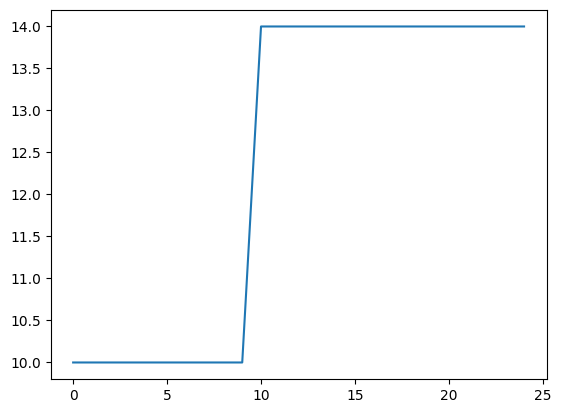

In [2]:
#r_vals = np.arange(14, 15, 1, dtype=np.float32)
r_vals = [10.0, 14.0]
def rho(t, r_vals = r_vals, step = 10):
    if t < step:
        return r_vals[0]
    elif t >= step:
        return r_vals[1]

plt.plot([rho(t) for t in range(0, 25)])

In [3]:
lorenz = ds.Lorenz(rho = rho)

#Generating data from Lorenz System with fixed parameters
dt = 0.05
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]
time_spans = [(0, 15)]
list = []

for t_span in time_spans:
    out = lorenz.solve(x0 = initial_conditions, t_span = t_span, dt = dt)
    list.append(np.expand_dims(out, axis=0))

data_full = np.concatenate(list, axis=0)
data_full.shape

(1, 300, 2, 3)

### Normalizing Data

In [4]:
norm = nodes.normalize_data(data_full.reshape(-1, 3))
data_norm = norm.normalize(data_full)

## Plotting 

In [5]:
data_norm.shape

(1, 300, 2, 3)

In [6]:
def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

    

In [7]:
data_norm[0, :, 0, 0].shape

(300,)

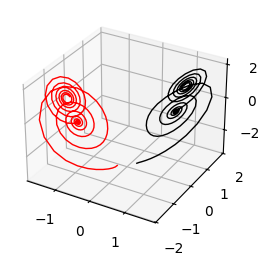

In [8]:

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
ax1.plot(xs=data_norm[0, :, 0, 0], ys=data_norm[0, :, 0, 1], zs=data_norm[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[0, :, 1, 0], ys=data_norm[0, :, 1, 1], zs=data_norm[0, :, 1, 2], color = 'red', linewidth = 1)   



# Training Neural ODE

In [9]:
model = nodes.Piecewise_Auto_NODE(spatial_dim=3, depth=2, width = 30, time_range=[0, 15], num_breakpoints=1, activation_func=nn.Tanh())

In [10]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
#t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

In [11]:
np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])

array([[ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
         1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
         1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
         2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
         2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
         3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
         3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
         4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
         4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
         4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
         5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
         5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,
      

In [12]:
times = np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])
t_eval_tensor = torch.tensor(times)
t_eval_tensor.shape

torch.Size([1, 300])

## Single Loop 

In [13]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [14]:

t_eval_tensor.shape[1]

300

In [15]:
#Single training loop
optimizer.zero_grad()

pred_x_list = []
for i in range(t_eval_tensor.shape[0]):

    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(3.8223, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([0.2599])



In [16]:
optimizer.zero_grad()




pred_x = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_tensor[0, :].float(), method='rk4', options={'step_size': dt})


loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor[0, :, :, :].float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(3.5405, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([0.2290])



## Main Training Loop

In [17]:
def batch(data: torch.tensor, t: torch.tensor, batch_length: int, num_batch: int): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).

    Modifed to allow for multiple time spans

    Parameters:
    -----------       
    data : torch.tensor
        The full dataset from which to sample batches. (num_time_spans, time, traj, dim)

    t : torch.tensor
        The corresponding time tensor. (num_time_spans, time)
    '''
    data_length = data.shape[1]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[:, ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[:, ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))
        
        #Each batch has shape (num_time_spans, batch_length, traj, dim) and each batch time has shape (num_time_spans, batch_length)

        return batch_list, batch_time_list

In [18]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [19]:
batch_length = 20
num_batch = 15
num_epochs = 1000

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float()) 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     
    
   

  0%|          | 1/1000 [00:02<35:27,  2.13s/it]

Epoch 0, Loss: 2.5446083545684814


  2%|▏         | 21/1000 [00:46<40:57,  2.51s/it]

Epoch 20, Loss: 0.7930956482887268


  4%|▍         | 41/1000 [01:25<34:41,  2.17s/it]

Epoch 40, Loss: 0.7172836661338806


  6%|▌         | 61/1000 [02:21<44:39,  2.85s/it]

Epoch 60, Loss: 0.7001471519470215


  8%|▊         | 81/1000 [03:16<46:45,  3.05s/it]

Epoch 80, Loss: 0.6831644177436829


 10%|█         | 101/1000 [04:11<41:50,  2.79s/it]

Epoch 100, Loss: 0.7411822080612183


 12%|█▏        | 121/1000 [05:06<40:24,  2.76s/it]

Epoch 120, Loss: 0.4862237572669983


 14%|█▍        | 141/1000 [06:01<39:34,  2.76s/it]

Epoch 140, Loss: 0.5539374947547913


 16%|█▌        | 161/1000 [06:56<39:03,  2.79s/it]

Epoch 160, Loss: 0.5710809826850891


 18%|█▊        | 181/1000 [07:49<37:12,  2.73s/it]

Epoch 180, Loss: 0.43906766176223755


 20%|██        | 201/1000 [08:42<37:10,  2.79s/it]

Epoch 200, Loss: 0.4491761326789856


 22%|██▏       | 221/1000 [09:36<35:50,  2.76s/it]

Epoch 220, Loss: 0.3178371787071228


 24%|██▍       | 241/1000 [10:31<35:38,  2.82s/it]

Epoch 240, Loss: 0.3267659544944763


 26%|██▌       | 261/1000 [11:25<34:59,  2.84s/it]

Epoch 260, Loss: 0.3504181504249573


 28%|██▊       | 281/1000 [12:19<33:26,  2.79s/it]

Epoch 280, Loss: 0.3430768549442291


 30%|███       | 301/1000 [13:13<32:16,  2.77s/it]

Epoch 300, Loss: 0.3028648793697357


 32%|███▏      | 321/1000 [14:06<31:12,  2.76s/it]

Epoch 320, Loss: 0.2944800555706024


 34%|███▍      | 341/1000 [15:00<30:29,  2.78s/it]

Epoch 340, Loss: 0.30152690410614014


 36%|███▌      | 361/1000 [15:54<28:43,  2.70s/it]

Epoch 360, Loss: 0.29378557205200195


 38%|███▊      | 381/1000 [16:47<28:33,  2.77s/it]

Epoch 380, Loss: 0.30688485503196716


 40%|████      | 401/1000 [17:40<27:21,  2.74s/it]

Epoch 400, Loss: 0.2820427119731903


 42%|████▏     | 421/1000 [18:33<26:51,  2.78s/it]

Epoch 420, Loss: 0.284125953912735


 44%|████▍     | 441/1000 [19:27<24:54,  2.67s/it]

Epoch 440, Loss: 0.2740621864795685


 46%|████▌     | 461/1000 [20:20<24:33,  2.73s/it]

Epoch 460, Loss: 0.2905876040458679


 48%|████▊     | 481/1000 [21:14<23:33,  2.72s/it]

Epoch 480, Loss: 0.2710091471672058


 50%|█████     | 501/1000 [22:07<22:32,  2.71s/it]

Epoch 500, Loss: 0.2684093713760376


 52%|█████▏    | 521/1000 [23:01<22:15,  2.79s/it]

Epoch 520, Loss: 0.25437864661216736


 54%|█████▍    | 541/1000 [23:54<21:06,  2.76s/it]

Epoch 540, Loss: 0.2513484060764313


 56%|█████▌    | 561/1000 [24:50<22:11,  3.03s/it]

Epoch 560, Loss: 0.26390811800956726


 58%|█████▊    | 581/1000 [25:46<19:13,  2.75s/it]

Epoch 580, Loss: 0.2507915198802948


 60%|██████    | 601/1000 [26:41<18:18,  2.75s/it]

Epoch 600, Loss: 0.2413705736398697


 62%|██████▏   | 621/1000 [27:35<17:34,  2.78s/it]

Epoch 620, Loss: 0.24160976707935333


 64%|██████▍   | 641/1000 [28:30<17:18,  2.89s/it]

Epoch 640, Loss: 0.23901191353797913


 66%|██████▌   | 661/1000 [29:31<21:40,  3.84s/it]

Epoch 660, Loss: 0.24008001387119293


 68%|██████▊   | 681/1000 [30:26<14:46,  2.78s/it]

Epoch 680, Loss: 0.2337929755449295


 70%|███████   | 701/1000 [31:21<13:58,  2.81s/it]

Epoch 700, Loss: 0.2347002476453781


 72%|███████▏  | 721/1000 [32:15<13:05,  2.82s/it]

Epoch 720, Loss: 0.22864891588687897


 74%|███████▍  | 741/1000 [33:09<12:01,  2.79s/it]

Epoch 740, Loss: 0.22299429774284363


 76%|███████▌  | 761/1000 [34:03<11:10,  2.80s/it]

Epoch 760, Loss: 0.2331363409757614


 78%|███████▊  | 781/1000 [44:54<3:52:02, 63.57s/it]  

Epoch 780, Loss: 0.21894796192646027


 80%|████████  | 801/1000 [46:15<13:27,  4.06s/it]  

Epoch 800, Loss: 0.21579456329345703


 82%|████████▏ | 821/1000 [47:34<12:29,  4.19s/it]

Epoch 820, Loss: 0.22897349298000336


 84%|████████▍ | 841/1000 [48:52<10:40,  4.03s/it]

Epoch 840, Loss: 0.21286827325820923


 86%|████████▌ | 861/1000 [50:13<10:30,  4.54s/it]

Epoch 860, Loss: 0.20570912957191467


 88%|████████▊ | 881/1000 [51:34<08:12,  4.14s/it]

Epoch 880, Loss: 0.20971977710723877


 90%|█████████ | 901/1000 [52:53<06:37,  4.02s/it]

Epoch 900, Loss: 0.21512041985988617


 92%|█████████▏| 921/1000 [54:11<05:19,  4.05s/it]

Epoch 920, Loss: 0.2086176574230194


 94%|█████████▍| 941/1000 [55:29<03:53,  3.95s/it]

Epoch 940, Loss: 0.22771389782428741


 96%|█████████▌| 961/1000 [56:46<02:37,  4.05s/it]

Epoch 960, Loss: 0.20182999968528748


 98%|█████████▊| 981/1000 [58:04<01:17,  4.08s/it]

Epoch 980, Loss: 0.19546586275100708


100%|██████████| 1000/1000 [59:18<00:00,  3.56s/it]


In [26]:
model.break_params

Parameter containing:
tensor([7.8063], requires_grad=True)

## Plotting results

Text(0.5, 0, 'Epochs')

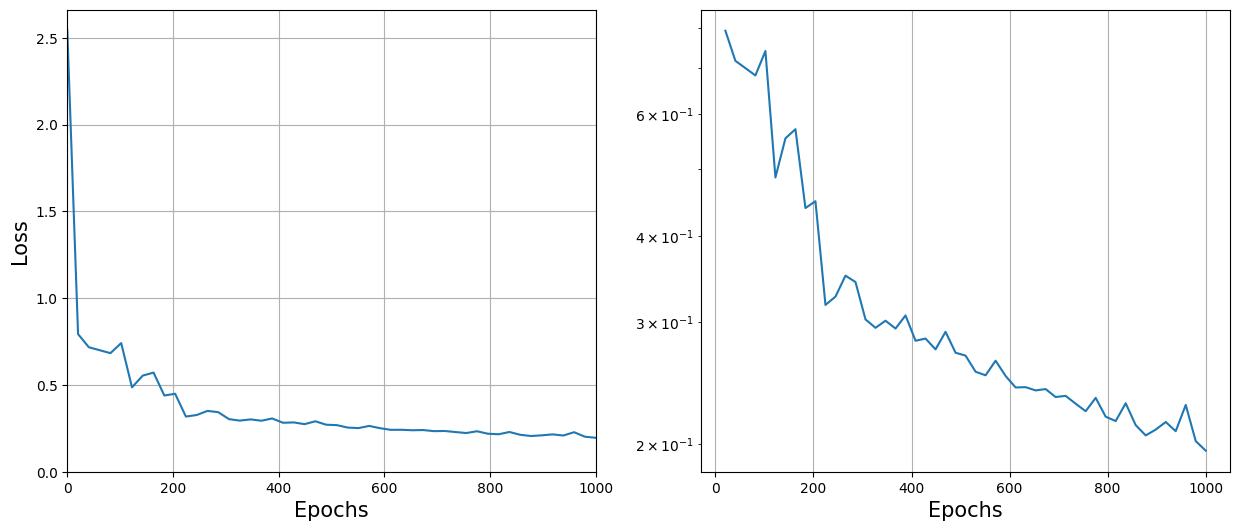

In [20]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [23]:
t_Start_pred = 0; t_Final_pred = 15
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

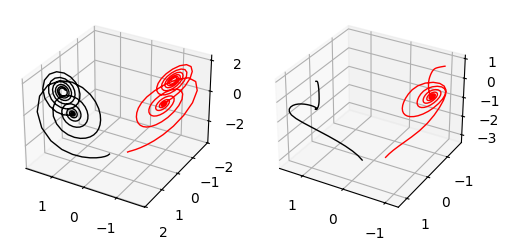

In [24]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[0, :, 0, 0], ys=training_data_tensor[0, :, 0, 1], zs=training_data_tensor[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[0, :, 1, 0], ys=training_data_tensor[0, :, 1, 1], zs=training_data_tensor[0, :, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()

In [52]:

def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[0, :index, 0, 0], ys=data_norm[0, :index, 0, 1], zs=data_norm[0, :index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[0, :index, 1, 0], ys=data_norm[0, :index, 1, 1], zs=data_norm[0, :index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

In [53]:
def plot_interact2(index):
        #Plotting results
        fig = plt.figure(figsize=(6, 8))

        #First Plot
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot(xs=training_data_tensor[0, :index, 0, 0], ys=training_data_tensor[0, :index, 0, 1], zs=training_data_tensor[0, :index, 0, 2], color = 'black', linewidth = 1 )
        ax1.plot(xs=training_data_tensor[0, :index, 1, 0], ys=training_data_tensor[0, :index, 1, 1], zs=training_data_tensor[0, :index, 1, 2], color = 'red', linewidth = 1 )

        #ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
        ax1.view_init(elev = 30, azim = 120)


        #Second Plot 
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot(xs=node_data[:index, 0, 0].detach().numpy(), ys=node_data[:index, 0, 1].detach().numpy(), zs=node_data[:index, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
        ax2.plot(xs=node_data[:index, 1, 0].detach().numpy(), ys=node_data[:index, 1, 1].detach().numpy(), zs=node_data[:index, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

        ax2.view_init(elev = 30, azim = 120)



In [47]:
node_data.shape

torch.Size([500, 2, 3])

In [48]:
model.break_params

Parameter containing:
tensor([8.2038], requires_grad=True)

In [54]:

interact(plot_interact2, index=IntSlider(min=0, max=500, step=1))

interactive(children=(IntSlider(value=0, description='index', max=500), Output()), _dom_classes=('widget-inter…

<function __main__.plot_interact2(index)>

## Bifurcation Diagram

In [ ]:
a = 1

In [ ]:
np.vectorize(lorenz.f)

In [ ]:
integ.solve_ivp(fun = np.vectorize(lorenz.f), t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', 
                t_eval = np.arange(t_Start, t_Final, dt), )




In [ ]:
r_eval = np.arange(0, 28, 0.1)
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]

t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [ ]:
x_list = []
r_list = []
for r in tqdm(r_eval):
    lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)
      



100%|██████████| 280/280 [02:05<00:00,  2.24it/s]
